# База знань про методи виготовлення різьби
Цей інтерактивний документ Jupyter призначений для роботи з базою знань про методи виготовлення різьби. Користувач може переглядати факти бази знань у вигляді таблиці або графа, створювати запити до бази знань, додавати (або видаляти) факти вручну або шляхом застосування механізму логічного виведення.

База знань складається з множини фактів і множини правил логічного виведення. Факти бази знань подані як триплети (суб'єкт, предикат, об'єкт) або (s, p, o). Триплети зберігаються у файлі формату CSV. Для зручного оброблення за допомогою пакету pandas ці триплети завантажуються в таблицю df (DataFrame). Ця таблиця df створюється в модулі mykb.

Віджети IPyWidgets (текстові поля і кнопки) дозволяють інтерактивну роботу з БЗ - пошук триплетів за шаблоном, додавання нових триплетів та їх видалення.

Для візуалізації графа бази знань використовуються пакети NetworkX (створює граф) та Matplotlib (візуалізує граф). NetworkX також можна використати для застосування різноманітних алгоритмів на графах.

Правила і машина виведення описані в модулі example3. Правила логічного виведення (rule1, rule2) дозволяють виводити нові факти за допомогою машини логічного виведення (reasoner). Машина виведення виконує "пряме виведення" та використовує підхід "а-ля RETE" для пришвидшення алгоритму, тобто будує дерево триплетів для швидкого пошуку.

Послідовність запуску через JupyterLite:

1. Відкрийте в браузері https://jupyter.org/try-jupyter/lab/
2. Перетягніть у File Browser (зліва) файли TextSelectInteractKB.ipynb, kb.csv, mykb.py, example3.py
3. Запустіть TextSelectInteractKB.ipynb і виконайте усі комірки

In [6]:
# установлюємо пакети
%pip install -q ipywidgets==8.1.3
%pip install -q pandas

In [7]:
# імпорт пакету для створення віджетів
import ipywidgets, pandas
# імпорт функції для візуалізації результатів
from IPython.display import display, Javascript

In [8]:
# з модуля mykb імпортуємо таблицю з фактами бази знань (s, p, o)
import sys
sys.path.append(".")
from mykb import df

In [9]:
# приклад запиту до бази знань:
# вивести таблицю усіх фактів (s, p, o), де s містить "різ" і p містить "перевага"
df[df["s"].str.contains("різ")][df["p"].str.contains("перевага")]

<ipython-input-9-e8856bee58a6>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df["s"].str.contains("різ")][df["p"].str.contains("перевага")]


,s,p,o
3,нарізання мітчиком,перевага,технологічність


In [10]:
fdf=None # pandas dataframe (таблиця)
import time
# функція виконується під час введення тексту в поля s, p, o
def f1(s, p, o):
    global fdf
    # таблиця fdf містить тільки ті тріплети, які відповідають введениму в поля s, p, o тексту
    fdf=df.loc[df["s"].str.contains(s)].loc[df["p"].str.contains(p)].loc[df["o"].str.contains(o)]
    display(fdf)
    time.sleep(1)

In [11]:
# функція виконується під час натиску на кнопки
def on_button_clicked(b):
    global df
    ndf = pandas.DataFrame([[s.value, p.value, o.value]], columns=['s', 'p', 'o']) # введений тріплет
    # якщо натиснуто "Add to KB"
    if b.description=="Add to KB":
        df=pandas.concat([df, ndf], ignore_index=True)
    # якщо натиснуто "Remove from KB"
    if b.description=="Remove from KB":
        df=pandas.concat([df, ndf], ignore_index=True).drop_duplicates(keep=False, ignore_index=True)
    
    # вивести назву кнопки і тріплет
    #display(Javascript(f"alert('{b.description}: ({s.value}, {p.value}, {o.value})')"))
    with output:
        print(b.description, s.value, p.value, o.value)
        
# створити кнопки і пов'язати їх з on_button_clicked
button1=ipywidgets.Button(description="Add to KB")
button1.on_click(on_button_clicked)
button2=ipywidgets.Button(description="Remove from KB")
button2.on_click(on_button_clicked)
output = ipywidgets.Output()
# кнопки і результати виведення
display(ipywidgets.HBox([button1, button2]), output);

Output()

In [12]:
# створити три текстові поля s, p, o
s=ipywidgets.Text(); p=ipywidgets.Text(); o=ipywidgets.Text()
# повязати їх з f1
ipywidgets.interact(f1, s=s, p=p, o=o);

interactive(children=(Text(value='', description='s'), Text(value='', description='p'), Text(value='', descrip…

In [21]:
# df = df.drop(index=[13]) # видалити за індексом

In [22]:
# імпорт пакетів networkx і matplotlib
import networkx
import matplotlib.pyplot as plt

In [23]:
# створити орієнтований граф, у якого вершинами є s та o, а дугами - p
G=networkx.DiGraph()
for r in fdf.itertuples(): # для кожного рядка таблиці
    G.add_edges_from([(r.s, r.o)], label=r.p) # створити вершини і дугу

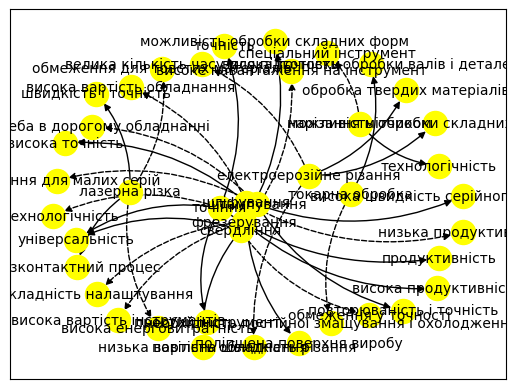

In [24]:
# списки дуг "перевага" та "недолік"
edges_p=[(u,v) for u,v,e in G.edges(data=True) if e['label']=="перевага"]
edges_n=[(u,v) for u,v,e in G.edges(data=True) if e['label']=="недолік"]
pos = networkx.spring_layout(G) # вибрати алгоритм візуалізації графа
# нарисувати вузли, мітки і дуги
networkx.draw_networkx_nodes(G, pos, node_color='yellow')
networkx.draw_networkx_labels(G, pos, font_size=10)
networkx.draw_networkx_edges(G, pos, edgelist=edges_p, connectionstyle='arc3, rad=0.2')
networkx.draw_networkx_edges(G, pos, edgelist=edges_n, style='dashed', connectionstyle='arc3, rad=0.2')
# зберегти граф у форматі SVG
plt.savefig("graph.svg", format="svg")

In [25]:
# імпорт правил і машини логічного виведення з модуля example3
from example3 import *

In [26]:
# наповнити множину F усіма фактами
F=set()
for row in df.itertuples():
    F.add((row.s, row.p, row.o))
# вивести нові факти за правилами rule1, rule2
A=reasoner(F, [rule1, rule2], ["перевага"], ["недолік"])
print(A) # усі факти
print(A-F) # нові факти

{('лазерна різка', 'перевага', 'швидкість і точність'), ('фрезерування', 'перевага', 'можливість обробки складних форм'), ('складність налаштування', 'недолік', 'фрезерування'), ('обмеження у точності', 'недолік', 'свердління'), ('фрезерування', 'перевага', 'висока продуктивність'), ('високе навантаження на інструмент', 'недолік', 'свердління'), ('нарізання мітчиком', 'недолік', 'спеціальний інструмент'), ('штампування', 'недолік', 'обмеження для малих серій'), ('шліфування', 'недолік', 'низька продуктивність'), ('нарізання мітчиком', 'перевага', 'технологічність'), ('висока вартість інструментів', 'недолік', 'фрезерування'), ('свердління', 'перевага', 'низька вартість обладнання'), ('лазерна різка', 'перевага', 'безконтактний процес'), ('штампування', 'перевага', 'повторюваність і точність'), ('лазерна різка', 'недолік', 'висока енерговитратність'), ('електроерозійне різання', 'недолік', 'повільна швидкість різання'), ('точіння', 'перевага', 'точність'), ('свердління', 'перевага', 'ун

In [27]:
df

,s,p,o
0,точіння,перевага,простий інструмент
1,точіння,перевага,точність
2,нарізання мітчиком,недолік,спеціальний інструмент
3,нарізання мітчиком,перевага,технологічність
4,точіння,перевага,продуктивність
5,точіння,перевага,універсальність
6,точіння,недолік,нетехнологічність
7,фрезерування,перевага,висока продуктивність
8,фрезерування,перевага,можливість обробки складних форм
9,фрезерування,недолік,висока вартість інструментів


In [28]:
df.to_csv('kb.csv', index=False) # зберегти у файл